In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import json
from statsmodels import robust

# Keras
from keras.models import Sequential
from keras.layers import Dense,Conv1D,MaxPooling1D,Flatten
# Train-Test
from sklearn.model_selection import train_test_split

/Users/technical/pupil-detection/pupil_api/my-test-env/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


#Read file from folder

In [2]:

file_list=[]
for dirpath,dirnames,filepath in walk('/Users/[USER_NAME]/Downloads/data'):
    for file in filepath:
        path=dirpath+'/'+file
        file_list.append(path)

file_list

['/Users/[USER_NAME]/Downloads/data/123802.json',
 '/Users/[USER_NAME]/Downloads/data/119509.json',
 '/Users/[USER_NAME]/Downloads/data/124352.json',
 '/Users/[USER_NAME]/Downloads/data/123995.json',
 '/Users/[USER_NAME]/Downloads/data/200633.json',
 '/Users/[USER_NAME]/Downloads/data/120546.json',
 '/Users/[USER_NAME]/Downloads/data/124773.json',
 '/Users/[USER_NAME]/Downloads/data/118170.json',
 '/Users/[USER_NAME]/Downloads/data/124731.json',
 '/Users/[USER_NAME]/Downloads/data/124727.json',
 '/Users/[USER_NAME]/Downloads/data/124737.json',
 '/Users/[USER_NAME]/Downloads/data/114456.json',
 '/Users/[USER_NAME]/Downloads/data/121922.json',
 '/Users/[USER_NAME]/Downloads/data/119414.json',
 '/Users/[USER_NAME]/Downloads/data/119506.json',
 '/Users/[USER_NAME]/Downloads/data/124311.json']

# speedy outlier threshold calculation

In [3]:
def get_threshold(d_list):
    d_base=[]
    for i,c in enumerate(d_list):
        if i==0:
            d_base.append(max(abs(d_list[i+1]-d_list[i]),0))
        elif i==len(d_list)-1:
            d_base.append(max(abs(d_list[i]-d_list[i-1]),0))
        else:
            d_base.append(max(abs(d_list[i+1]-d_list[i]),abs(d_list[i]-d_list[i-1])))

    median_d_base=np.median(d_base)
    d_base_new=[abs(x-median_d_base) for x in d_base]

    mad_base_old=robust.mad(np.array(d_base),c=1)
    mad_base=np.median(d_base_new)
    threshold_max = np.median(d_list)+40*mad_base
    threshold_min = np.median(d_list)-40*mad_base
    return threshold_min,threshold_max

# cleaning data for dataframe generation

In [4]:
t_list=[]
for file_path in file_list:
    print('reading file : ',file_path)
    participant_id=file_path.split('/')[-1:][0].split('.')[0]
    f=open(file_path)
    json_data=json.load(f)

    for trail in json_data.get('trials'):
        tmp_list=[]
        rating=trail.get('rating')
        diameter_list=trail.get('pupil_dilation')
        # print(diameter_list)
        # artifact outlier detection start
        if 0 in diameter_list:
            # print('0 present diameter : ')
            diameter_indices = [i for i, x in enumerate(diameter_list) if x == 0]
            # print(diameter_indices)
            for index in diameter_indices:

                st_index = 0 if (index-5)<0 else (index-5)
                diameter_list[st_index:index]=[0 for x in range(index-st_index)]
                end_index = index+5 if (index+5)<len(diameter_list) else len(diameter_list)
                diameter_list[index:end_index]=[0 for x in range(end_index-index)]

        # artifact outlier detection end

        #speedy outlier detection start

        threshold_diameter_min,threshold_diameter_max  = get_threshold(diameter_list)
        diameter_list = [0 if x>threshold_diameter_max else x for x in diameter_list ]
        diameter_list = [0 if x<threshold_diameter_min else x for x in diameter_list ]

        # print('0 count: ',diameter_list.count(0))
        # print('before: ',diameter_list, ' len: ',len(diameter_list))

        dt_diameter=pd.DataFrame(diameter_list,columns=['x'])
        dt_diameter['x']=dt_diameter['x'].replace(0,np.nan)
        dt_diameter=dt_diameter.interpolate('index',limit_direction='both')

        #speedy outlier detection end
        #save data to list for generating dataframe
        diameter_list = dt_diameter['x'].tolist()
        diameter_list=diameter_list[0:296]
        diameter_list.append(rating)
        # tmp_list.append(diameter_list)
        t_list.append(diameter_list)
        # print('after : ',diameter_list)
    f.close()




reading file :  /Users/[USER_NAME]/Downloads/data/123802.json
reading file :  /Users/[USER_NAME]/Downloads/data/119509.json
reading file :  /Users/[USER_NAME]/Downloads/data/124352.json
reading file :  /Users/[USER_NAME]/Downloads/data/123995.json
reading file :  /Users/[USER_NAME]/Downloads/data/200633.json
reading file :  /Users/[USER_NAME]/Downloads/data/120546.json
reading file :  /Users/[USER_NAME]/Downloads/data/124773.json
reading file :  /Users/[USER_NAME]/Downloads/data/118170.json
reading file :  /Users/[USER_NAME]/Downloads/data/124731.json
reading file :  /Users/[USER_NAME]/Downloads/data/124727.json
reading file :  /Users/[USER_NAME]/Downloads/data/124737.json
reading file :  /Users/[USER_NAME]/Downloads/data/114456.json
reading file :  /Users/[USER_NAME]/Downloads/data/121922.json
reading file :  /Users/[USER_NAME]/Downloads/data/119414.json
reading file :  /Users/[USER_NAME]/Downloads/data/119506.json
reading file :  /Users/[USER_NAME]/Downloads/data/124311.json


In [6]:
df=pd.DataFrame(t_list)

In [7]:
df['rating']=df[296]

In [8]:
df.pop(296)

0      3.0
1      4.0
2      0.0
3      3.0
4      3.0
      ... 
475    1.0
476    3.0
477    3.0
478    4.0
479    3.0
Name: 296, Length: 480, dtype: float64

In [9]:
df

,0,1,2,3,4,5,6,7,8,9,...,287,288,289,290,291,292,293,294,295,rating
0,3.216797,3.216797,3.216797,3.216797,3.216797,3.216797,3.216797,3.216797,3.216797,3.216797,...,3.316177,3.317657,3.310822,3.301193,3.303116,3.304520,3.313171,3.316513,3.312958,3.0
1,3.470810,3.470810,3.471359,3.459839,3.457794,3.467407,3.464661,3.459854,3.453629,3.452072,...,3.441101,3.442383,3.447678,3.446960,3.437622,3.431137,3.422394,3.420547,3.423767,4.0
2,3.403854,3.405106,3.406250,3.400970,3.413254,3.421799,3.410629,3.402542,3.394821,3.384430,...,3.481216,3.479828,3.469696,3.469711,3.468948,3.467346,3.464188,3.462677,3.471527,0.0
3,3.737244,3.737244,3.733856,3.743835,3.743332,3.742188,3.741837,3.743469,3.746597,3.744690,...,3.576734,3.577300,3.577865,3.578430,3.568329,3.566010,3.568863,3.546310,3.546860,3.0
4,3.293930,3.300217,3.301544,3.304016,3.309082,3.316055,3.329453,3.331055,3.325867,3.321960,...,3.511581,3.515945,3.517441,3.521683,3.513153,3.523087,3.533752,3.544464,3.551071,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,3.646790,3.650696,3.645737,3.651306,3.658722,3.650162,3.639297,3.642319,3.643173,3.644501,...,3.826083,3.828249,3.830415,3.832581,3.834747,3.879456,3.916977,3.932816,3.936722,1.0
476,3.546082,3.522751,3.506439,3.495499,3.490326,3.484406,3.470108,3.460754,3.457748,3.447495,...,3.825790,3.825790,3.825790,3.825790,3.825790,3.825790,3.825790,3.825790,3.825790,3.0
477,3.638428,3.641861,3.642761,3.636490,3.628525,3.632095,3.635986,3.631821,3.631378,3.635910,...,3.744934,3.746774,3.748613,3.750453,3.752292,3.754132,3.755971,3.757811,3.759650,3.0
478,3.480133,3.480133,3.480133,3.480133,3.480133,3.480133,3.482941,3.493301,3.496399,3.502731,...,3.817566,3.804489,3.778717,3.763626,3.754562,3.744064,3.727539,3.722961,3.713455,4.0


In [9]:
df['rating']=df['rating'].astype(int)

In [10]:
df=df[df['rating']!=0]

In [11]:
df.groupby('rating').count()

,0,1,2,3,4,5,6,7,8,9,...,286,287,288,289,290,291,292,293,294,295
rating,,,,,,,,,,,,,,,,,,,,,
1,58,58,58,58,58,58,58,58,58,58,...,58,58,58,58,58,58,58,58,58,58
2,147,147,147,147,147,147,147,147,147,147,...,147,147,147,147,147,147,147,147,147,147
3,201,201,201,201,201,201,201,201,201,201,...,201,201,201,201,201,201,201,201,201,201
4,68,68,68,68,68,68,68,68,68,68,...,68,68,68,68,68,68,68,68,68,68


# converting output type
# 0 == dislike  for rating 1,2
# 1 == like  for rating 3,4

In [13]:
df['remarks']=df['rating'].apply(lambda x: 0 if x in [1,2] else 1)

# generatin input and output

In [29]:
dataset = df[:295].values
df_t = df.drop("rating", axis = 1)
x = df_t.drop("remarks", axis = 1)
y = df['remarks']

# time series augmentation

In [15]:
from tsaug import  Drift

In [38]:
my_aug = (
    Drift(max_drift=(0.1, 0.3))
)

In [43]:
x_aug=[]
y_aug=[]

In [44]:
for i in zip(x.values,y.values):
    x_aug.append(my_aug.augment(i[0]))
    y_aug.append(i[1])

In [45]:
df_x_aug=pd.DataFrame(x_aug)
df_y_aug=pd.DataFrame(y_aug)
x=pd.concat([x,df_x_aug])
y=pd.concat([y,df_y_aug])


In [46]:
print(len(x),len(y))

1896 1896


In [47]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y, test_size=0.10)

# model generation
# CNN

In [33]:
model = Sequential()
# model.add(Dense(60, input_shape = (296,), activation = "relu"))
model.add(Conv1D(filters=1, kernel_size=2, padding='same', activation='relu',
                         input_shape=(296,1 )))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=3, kernel_size=3, padding='same', activation='softmax',
                         input_shape=(296,1 )))
model.add(MaxPooling1D(pool_size=3))


model.add(Flatten())
# model.add(Dense(30, activation = "relu"))
# model.add(Dropout(0.2))
model.add(Dense(15, activation = "softmax"))
# model.add(Dropout(0.1))
model.add(Dense(2, activation = "softmax"))
# model.add(Dense(units=4, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 296, 1)            3         
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 148, 1)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 148, 3)            12        
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 49, 3)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 147)               0         
                                                                 
 dense_4 (Dense)             (None, 15)               

In [49]:
model.fit(x_train, y_train, verbose=1, epochs=100)

Epoch 1/100
54/54 [==============================] - 0s 3ms/step - loss: 0.2500 - accuracy: 0.5428
Epoch 2/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.5422
Epoch 3/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.5428
Epoch 4/100
54/54 [==============================] - 0s 2ms/step - loss: 0.2500 - accuracy: 0.5422
Epoch 5/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.5434
Epoch 6/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.5422
Epoch 7/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.5428
Epoch 8/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.5428
Epoch 9/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.5422
Epoch 10/100
54/54 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.5428
Epoch 11/

In [53]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(x_test)

array([[0.5000871 , 0.49991292],
       [0.5000211 , 0.49997893],
       [0.49990094, 0.50009906],
       [0.5000877 , 0.49991235],
       [0.49988458, 0.5001154 ],
       [0.49997926, 0.5000208 ],
       [0.49988753, 0.5001124 ],
       [0.5000224 , 0.49997765],
       [0.49995035, 0.50004965],
       [0.49977154, 0.5002285 ],
       [0.4998116 , 0.50018835],
       [0.49991778, 0.50008225],
       [0.49993014, 0.50006986],
       [0.50007874, 0.4999212 ],
       [0.5000541 , 0.49994594],
       [0.50016546, 0.49983448],
       [0.49989536, 0.5001046 ],
       [0.50002795, 0.4999721 ],
       [0.499888  , 0.50011194],
       [0.49978533, 0.50021476],
       [0.49965632, 0.5003437 ],
       [0.5003259 , 0.49967414],
       [0.49999374, 0.50000626],
       [0.4999621 , 0.5000379 ],
       [0.5000166 , 0.4999834 ],
       [0.5000676 , 0.4999324 ],
       [0.5000495 , 0.49995056],
       [0.50014985, 0.49985012],
       [0.49984175, 0.5001583 ],
       [0.500126  , 0.49987403],
       [0.

# as softmax activation function output layer it return probability of output
# discrete output is generated from that

In [55]:
y_pred_final=[]
for items in y_pred:
    if items[0]<items[1]:
        y_pred_final.append(1)
    else:
        y_pred_final.append(0)

In [62]:
# np.array(y_pred_final)
confusion_matrix(y_test, y_pred_final)

array([[51, 37],
       [49, 53]])

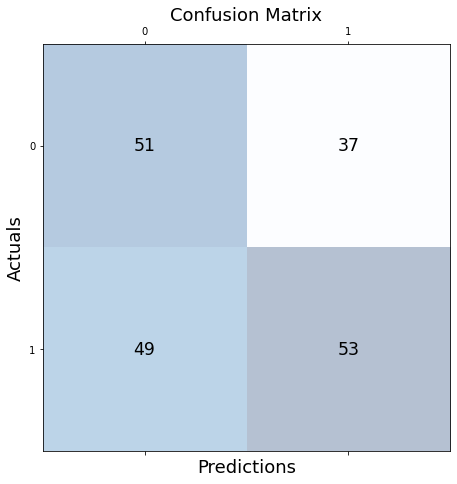

In [64]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_final)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_final))

              precision    recall  f1-score   support

           0       0.51      0.58      0.54        88
           1       0.59      0.52      0.55       102

    accuracy                           0.55       190
   macro avg       0.55      0.55      0.55       190
weighted avg       0.55      0.55      0.55       190

